In [1]:
import numpy as np
from PIL import Image
import os, sys
import cv2


x_data = []

def resizeToGray(path):
    dirs = os.listdir( path )
    for item in dirs:
        if os.path.isfile(path+item):
            im = cv2.imread(path+item, cv2.IMREAD_UNCHANGED)
            f, e = os.path.splitext(path+item)
            scale_percent = 3 # percent of original size
            width = int(im.shape[1] * scale_percent / 100)
            height = int(im.shape[0] * scale_percent / 100)
            dim = (width, height)
            imResize = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
            imGray = cv2.cvtColor(imResize, cv2.COLOR_BGR2GRAY)
            x_data.append(imGray)

resizeToGray("E:/Clase/SI/Data/train/Type_1/")
y_type1 = np.ones((len(x_data),), dtype=int)

resizeToGray("E:/Clase/SI/Data/train/Type_2/")
y_type2 = np.full(len(x_data)-len(y_type1), 2)

resizeToGray("E:/Clase/SI/Data/train/Type_3/")
y_type3 = np.full(len(x_data)-len(y_type1)-len(y_type2), 3)

y_data = np.concatenate((y_type1, y_type2, y_type3), axis = 0)

In [2]:
print(len(x_data), len(y_type1), len(y_type2), len(y_type3), len(y_type1)+len(y_type2)+len(y_type3))

1481 250 781 450 1481


(<matplotlib.image.AxesImage at 0x23fd24fd000>, (-0.5, 72.5, 96.5, -0.5))

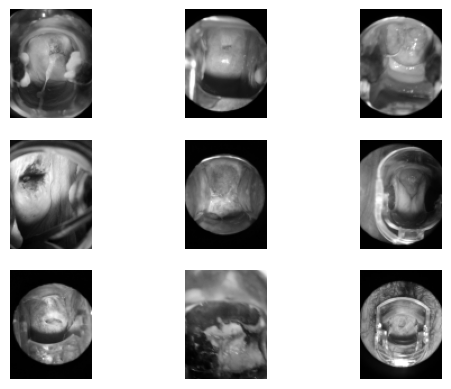

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

u1 = random.choice(x_data)
u2 = random.choice(x_data)
u3 = random.choice(x_data)
u4 = random.choice(x_data)
u5 = random.choice(x_data)
u6 = random.choice(x_data)
u7 = random.choice(x_data)
u8 = random.choice(x_data)
u9 = random.choice(x_data)

plt.subplot(331)
plt.imshow(u1, "gray"), plt.axis("off")
plt.subplot(332)
plt.imshow(u2, "gray"), plt.axis("off")
plt.subplot(333)
plt.imshow(u3, "gray"), plt.axis("off")
plt.subplot(334)
plt.imshow(u4, "gray"), plt.axis("off")
plt.subplot(335)
plt.imshow(u5, "gray"), plt.axis("off")
plt.subplot(336)
plt.imshow(u6, "gray"), plt.axis("off")
plt.subplot(337)
plt.imshow(u7, "gray"), plt.axis("off")
plt.subplot(338)
plt.imshow(u8, "gray"), plt.axis("off")
plt.subplot(339)
plt.imshow(u9, "gray"), plt.axis("off")